<a href="https://colab.research.google.com/github/simon-mellergaard/GAI-with-LLMs/blob/main/Project%20codes/Assignment02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2


> *Perform the fine-tuning exercise from Chapter 6 in Hands-on Generative AI with Transformers with Transformers and Diffusion Models, but use HuggingFaceTB/SmolLM2-135M instead.  
The goal is to tweak tuning parameters to get healthy looking training-validation curves and reasonable sounding output. Show examples of each from two selected training runs: One that shows warnings signs and one that shows the desired behavior.*

## Setup

Loading libraries, logging, setting device.

In [1]:
# Libraries
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
import warnings

# Functions
from datasets import load_dataset
from transformers import AutoModelForCausalLM
from transformers import AutoTokenizer
from transformers import TrainingArguments
from transformers import Trainer
from transformers import pipeline
from transformers import DataCollatorForLanguageModeling
from google.colab import userdata
from huggingface_hub import login as login_hf
from wandb import login as login_wandb

# Suppress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

2025-09-19 13:30:33.333160: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758288633.517087      76 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758288633.576971      76 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Logging in to Huggingface and wandb
os.environ['HF_TOKEN'] = userdata.get('HF')
os.environ['WANDB_TOKEN'] = userdata.get('wandb')
login_hf(os.environ['HF_TOKEN'])
login_wandb(key = os.environ['WANDB_TOKEN'])

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: simonmellergaard (simonmellergaard-aarhus-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [3]:
# Setting up the device (GPU). Code is taken from the genaibook-module.
def get_device(cuda_ordinal=None):
    if torch.cuda.is_available():
        return torch.device("cuda", cuda_ordinal)
    if torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")

device = get_device()

## Creating a robust text-generation model

The code is based on chapter 6 from the Hands-on book. It will fine-tune a model for text generation. This will still use the ag-news dataset

In [4]:
raw_datasets = load_dataset("ag_news")

filtered_datasets = raw_datasets.filter(lambda example: example["label"] == 2)
filtered_datasets = filtered_datasets.remove_columns("label")

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Filter:   0%|          | 0/120000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/7600 [00:00<?, ? examples/s]

The model to be used is [SmolLM v2](https://huggingface.co/HuggingFaceTB/SmolLM2-135M). This model is loaded, and the datset is tokenized.

In [5]:
model_id = "HuggingFaceTB/SmolLM2-135M"
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = (
    tokenizer.eos_token
)
model = AutoModelForCausalLM.from_pretrained(model_id).to(device)

# Tokenizing
def tokenize_function(batch):
    return tokenizer(batch["text"], truncation=True)

tokenized_datasets = filtered_datasets.map(
    tokenize_function,
    batched=True,
    remove_columns=["text"],  # We only need the input_ids and attention_mask
)

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/831 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/269M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1900 [00:00<?, ? examples/s]

A data collator is also speicfied for the model for further padding the batches.

In [6]:
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

The training arguments for the model is defined, and passed into the actual trainer. This is the initial run, where training paramters has not been adjusted accordingly.

In [7]:
training_args = TrainingArguments(
    "business-news-generator-smollm2-initial",
    per_device_train_batch_size=8,
    weight_decay=0.1,
    lr_scheduler_type="cosine",
    learning_rate=8e-6,                    # low learning rate
    num_train_epochs=2,
    eval_strategy="steps",
    eval_steps=200,
    logging_steps=200,
)
trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_datasets["train"].select(range(5000)),
    eval_dataset=tokenized_datasets["test"],
)

The model is trained:

In [8]:
train_result = trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss,Validation Loss
200,3.395300,3.263834
400,3.068300,3.141369
600,2.982700,3.088359
800,2.842300,3.065624
1000,2.817800,3.056335
1200,2.826500,3.054132


In [9]:
trainer.push_to_hub()

Uploading...:   0%|          | 0.00/538M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/simon-mellergaard/business-news-generator-smollm2-initial/commit/9605b9cdad6302aaad75b3d394da19f25684dbe4', commit_message='End of training', commit_description='', oid='9605b9cdad6302aaad75b3d394da19f25684dbe4', pr_url=None, repo_url=RepoUrl('https://huggingface.co/simon-mellergaard/business-news-generator-smollm2-initial', endpoint='https://huggingface.co', repo_type='model', repo_id='simon-mellergaard/business-news-generator-smollm2-initial'), pr_revision=None, pr_num=None)

The training-validation loss curves should be evaluated for the model. As multiple plots will be produced, a function is made to make the plots.

In [10]:
def plot_loss(trainer, title='Training and Validation Loss over Epochs'):
    # Creating dataframe for plotting. Load pandas and matplotlib
    history = trainer.state.log_history[:-1]
    results = pd.DataFrame(columns=pd.DataFrame(history).columns)
    # The results are stored in alternating order in the results, so it is
    # iterated through every second instance
    for i in range(len(history)):
        if i % 2 == 0:
            new_row = pd.DataFrame(history[i], index=[0])
            results = pd.concat([results, new_row], ignore_index=True)
        else:
            # The bottom most row is inserted the specific columns
            results.loc[len(results) - 1, history[i].keys()] = history[i]
    # Plotting the results
    plt.figure(figsize=(7, 5))
    plt.plot(results['epoch'], results['loss'], marker='o', label='Training Loss', color = 'blue')
    plt.plot(results['epoch'], results['eval_loss'], marker='o', label='Validation Loss', color = 'orange')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

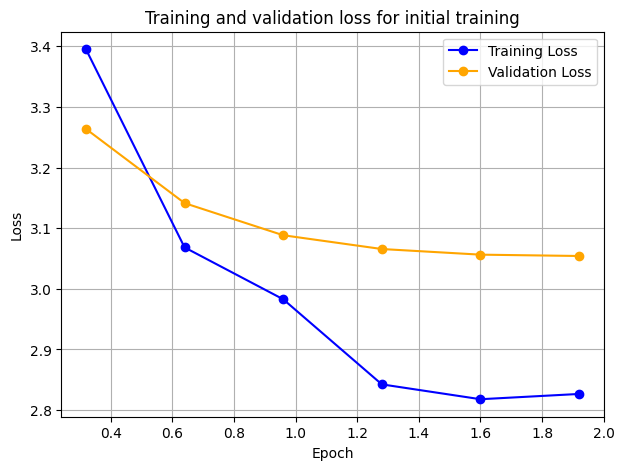

In [11]:
plot_loss(trainer, 'Training and validation loss for initial training')

There is a clear warning sign in the plot of the loss curve, as it does not seem to train at all. This could be because of a very low learning rate, or not enough data.

Additionally, it is interesting to look at some generated text from the model, to see if it is coherent. Another function will be defined for this.

In [12]:
# Prints output of three common prompts
def print_output(pipe, text = ['Q1', 'Wall', 'Google'], temperature=0.1):
    import pprint
    text = text
    max_tokens = 50
    for i in text:
        pprint.pp(
            pipe(i, do_sample=True, temperature=temperature, max_new_tokens=max_tokens)[0][
                "generated_text"
            ]
        )

In [13]:
pipe = pipeline(
    "text-generation",
    model=trainer.model,
    tokenizer=tokenizer,
    device=device,
)

Device set to use cuda


In [14]:
print_output(pipe)

("Q1000: The 2000-Year-Old Pizza Shop Is Back, But It's Not The Same\n"
 '\n'
 'By:, \xa0Updated: \xa0Tuesday, 10th May 2000 ')
('Wall 1.3 Million in US Tax Payer Payrolls  NEW YORK (Reuters) - US tax '
 'payers  paid a combined 1.3 million in 1993, the highest level in 20 years,')
('Google: Google to buy Google Inc. #39;s search engine giant Google Inc. '
 '#39;s search engine giant Google Inc. #39;s search engine giant #39;s search '
 'engine giant #39;s')


The output doesn't seem to make much sence - a lack of coherence.

## Improving the model

Now, a new model will be trained to improve the loss curve. Here a lower learning rate is used, as well as more data. Additionally, only the model with the lowest evaluation loss will be saved, which ensures that we do not fetch a model that has been overfit.

In [7]:
# Specifying the model again.
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = (
    tokenizer.eos_token
)
model = AutoModelForCausalLM.from_pretrained(model_id).to(device)

# Tokenizing
def tokenize_function(batch):
    return tokenizer(batch["text"], truncation=True)

tokenized_datasets = filtered_datasets.map(
    tokenize_function,
    batched=True,
    remove_columns=["text"],  # We only need the input_ids and attention_mask
)
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

Map:   0%|          | 0/1900 [00:00<?, ? examples/s]

In [8]:
training_args = TrainingArguments(
    "business-news-generator-smollm2-better",
    per_device_train_batch_size=8,
    weight_decay=0.1,
    lr_scheduler_type="cosine",
    learning_rate=5e-5,             # Adjusted learning rate
    num_train_epochs=2,
    eval_steps=200,
    logging_steps=200,
    eval_strategy="steps",
    save_steps=200,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
)
trainer2 = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_datasets["train"].select(range(10000)), # More data
    eval_dataset=tokenized_datasets["test"],
)

In [9]:
train_result2 = trainer2.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss,Validation Loss
200,3.038800,2.988560
400,2.777400,2.883885
600,2.679900,2.825753
800,2.645200,2.787690
1000,2.537300,2.757776
1200,2.474100,2.731739
1400,2.244500,2.741526
1600,2.163600,2.736773
1800,2.133800,2.726194
2000,2.133300,2.723348


RuntimeError: [enforce fail at inline_container.cc:626] . unexpected pos 965388736 vs 965388624

In [ ]:
train_result2 = trainer2.train()

Step,Training Loss,Validation Loss
200,3.886500,4.992385
400,3.936500,4.956767
600,3.994400,4.959145
800,4.025000,4.950057
1000,3.922100,4.935201
1200,3.868500,4.930513
1400,3.806600,4.960511
1600,3.865300,4.946312
1800,3.792000,4.938413
2000,3.822800,4.943399


  ...vents.1758280189.31833c1255c5.459.5:  35%|###4      | 2.99kB / 8.54kB            

There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


In [10]:
trainer2.push_to_hub()

OSError: [Errno 28] No space left on device

The results can now be plotted

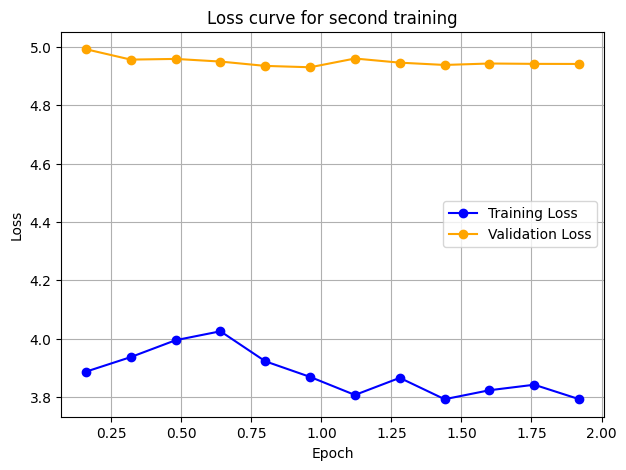

In [ ]:
plot_loss(trainer2, title='Loss curve for second training')

/tmp/ipython-input-2065102172.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row], ignore_index=True)


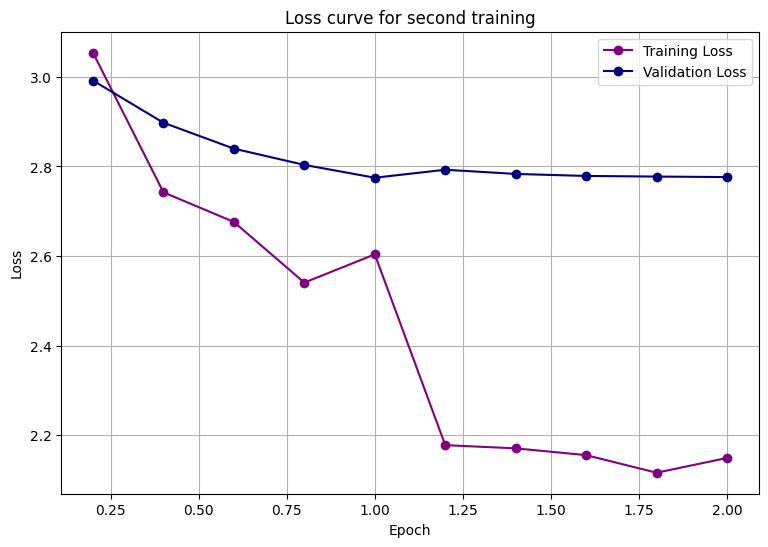

In [ ]:
plot_loss(trainer2, title='Loss curve for second training')

There is a steady decend until epoch 2 begins, where there is a quite big spike downwards.
Let's take a look at some output from the model

In [ ]:
pipe2 = pipeline(
    "text-generation",
    model=trainer2.model,
    tokenizer=tokenizer,
    device=device,
)

Device set to use cuda


Printing some outputs

In [ ]:
print_output(pipe2)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Q100,000 Profit, Shares Up  NEW YORK (Reuters) - U.S. stocks were up 10 percent by early morning on Monday as investors bought  shares of U.S. technology company Qual
Wall Street: Oil Prices Rise; Oil Prices Rise Oil prices rose on Friday, driven by higher crude oil prices and concerns that the US economy may slow down.  NEW YORK (CNN/Money) - Oil prices rose on Friday, driven by higher
Google #39;s IPO Price Targets  #39;\$55 a Share  NEW YORK (Reuters) - Google Inc. shares are set to  trade at \$55 a share on Nasdaq
